In [6]:
import os
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
import matplotlib.pyplot as plt
import nltk  
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau

In [2]:
GLOVE_DIR='C:/Users/preet/.keras/Datasets'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [3]:
def plot_accuracy_epoch(epochs,metric1,metric2):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, metric1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(epochs, metric2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training and Validation set losses')
    plt.show()

def plot_zoom(from_epoch,metric1,metric2):
    epochs_zoom = epochs[from_epoch:]
    metric1_zoom = metric1[from_epoch:]
    metric2_zoom = metric2[from_epoch:]

    plot_accuracy_epoch(epochs_zoom,metric1_zoom,metric2_zoom)  
    

def text_cleaner(text):
    text = text.lower()
    text = re.sub(r"\n"," ",text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub(r"\d+",'',text)        #Remove digits
    text = text.translate(str.maketrans('','', string.punctuation)) #remove punctuations
    text = re.sub(r'http\S+|www.\S+', r' ', text) #Remove http
    text= text.strip()
    return text

seed=12

In [4]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
submission=pd.read_csv("sample_submission.csv")

In [7]:
train_data['cleaned'] = train_data['comment_text'].apply(lambda x : text_cleaner(x))
test_data['cleaned'] = test_data['comment_text'].apply(lambda x : text_cleaner(x))

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
num_classes=len(list_classes)
train_label = train_data[list_classes].values

train_features = train_data['cleaned'].to_numpy()
X_test = test_data['cleaned'].to_numpy()

In [8]:
X_train, X_cv, y_train, y_cv = train_test_split(train_features, train_label, test_size = 0.2, random_state = seed)

In [9]:
vocab_size = 50000
embedding_dim = 100
max_length = 100 #max([max([len(i.split()) for i in X_test]), max([len(i.split()) for i in X_cv]), max([len(i.split()) for i in X_train])])
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
batch_size=128

In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(len(word_index))

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_cv)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

full_train_sequences = tokenizer.texts_to_sequences(train_features)
full_train_padded = pad_sequences(full_train_sequences, padding=padding_type, maxlen=max_length)

195587


In [11]:
hits = 0
misses = 0
nb_words = min(vocab_size, len(word_index))
embedding_matrix = np.zeros((nb_words , embedding_dim))
for word, i in word_index.items():
    if i >= vocab_size: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 40497 words (9502 misses)


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 32)           14976     
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

In [13]:
num_epochs = 2
history_nn=model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_cv),callbacks=[reduce_lr])

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 301s 2ms/sample - loss: 0.0975 - accuracy: 0.9641 - val_loss: 0.0623 - val_accuracy: 0.9782
Epoch 2/2
127656/127656 [==============================] - 279s 2ms/sample - loss: 0.0657 - accuracy: 0.9766 - val_loss: 0.0604 - val_accuracy: 0.9791


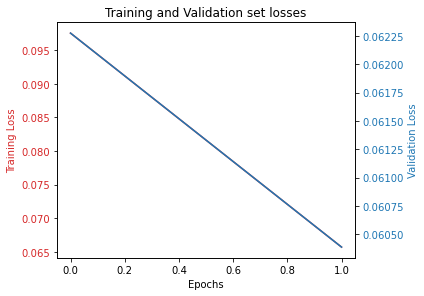

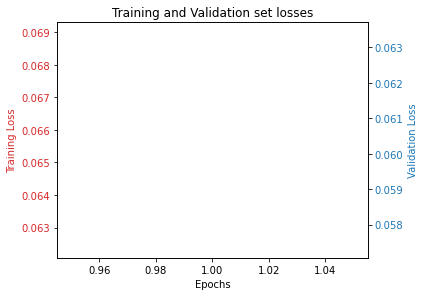

In [14]:
train_loss=history_nn.history['loss']
valid_loss=history_nn.history['val_loss']
epochs=range(len(train_loss))

plot_accuracy_epoch(epochs,train_loss,valid_loss)
plot_zoom(int(0.8*num_epochs),train_loss,valid_loss)

In [ ]:
num_epochs = 2
history_nn=model.fit(full_train_padded, train_label, epochs=num_epochs)

In [15]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [16]:
y_test = model.predict([testing_padded], batch_size=1024, verbose=1)
submission[list_classes] = y_test
submission.to_csv('submission.csv', index=False)

153164/153164 [==============================] - 35s 231us/sample
